<a href="https://colab.research.google.com/github/JuShiCode/JuShiCode/blob/main/%D0%9E%D0%B1%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D0%BA%D0%B0_%D1%82%D0%B5%D0%BA%D1%81%D1%82%D0%BE%D0%B2_%D1%81_%D0%BF%D0%BE%D0%BC%D0%BE%D1%89%D1%8C%D1%8E_%D0%BD%D0%B5%D0%B9%D1%80%D0%BE%D1%81%D0%B5%D1%82%D0%B5%D0%B9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Загружаем библиотеки

In [ ]:
from google.colab import files # Для работы с файлами 
import numpy as np # Для работы с данными 
import pandas as pd # Для работы с таблицами
import matplotlib.pyplot as plt # Для вывода графиков
import os # Для работы с файлами
%matplotlib inline

from tensorflow.keras import utils # Для работы с категориальными данными
from tensorflow.keras.models import Sequential # Полносвязная модель
from tensorflow.keras.layers import Dense, Dropout, SpatialDropout1D, BatchNormalization, Embedding, Flatten, Activation # Слои для сети
from tensorflow.keras.preprocessing.text import Tokenizer # Методы для работы с текстами и преобразования их в последовательности
from tensorflow.keras.preprocessing.sequence import pad_sequences # Метод для работы с последовательностями
from tensorflow.keras.optimizers import Adam #Оптимизатор

from sklearn.preprocessing import LabelEncoder # Метод кодирования тестовых лейблов
from sklearn.model_selection import train_test_split # Для разделения выборки на тестовую и обучающую
from google.colab import drive # Для работы с Google Drive
import time # Импортируем библиотеку time

In [ ]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


##Обрабатываем данные

In [ ]:
!rm -R /content/texts #удаляем папку texts

rm: cannot remove '/content/texts': No such file or directory


In [ ]:
#создаём папку и распаковываем в неё файлы
!unzip -q '/content/drive/My Drive/Neural University/Базы/Тексты писателей.zip' -d /content/texts 

In [ ]:
def readText(fileName): #функция для чтения файла принимает на вход имя файла
  f = open(fileName, 'r')        #открываем файл в режиме чтения
  text = f.read()                #читаем текст
  text = text.replace("\n", " ") #переводим в пробелы переносы строки
  
  return text                    #возвращаем текст

className = ["О. Генри", "Стругацкие", "Булгаков", "Саймак", "Фрай", "Брэдберри"] # Объявляем интересующие нас классы
nClasses = len(className) # Считаем количество классов

In [ ]:
#Загружаем обучающие тексты

trainText = [] #Формируем обучающие тексты
testText = [] #Формируем тестовые тексты

#Формирование необходимо произвести следующим образом 
#Класс каждого i-ого эллемента в обучающей выборке должен соответствовать 
#классу каждого i-ого эллемента в тестовой выборке

for i in className: 
  for j in os.listdir('texts/'): 
    if i in j: #Проверяем, содержит ли файл j в названии имя класса i
      
      if 'Обучающая' in j: 
        trainText.append(readText('texts/' + j)) #добавляем в обучающую выборку
        print(j, 'добавлен в обучающую выборку') #Выводим информацию
      if 'Тестовая' in j: 
        testText.append(readText('texts/' + j)) #добавляем в обучающую выборку
        print(j, 'добавлен в тестовую выборку') #Выводим информацию
  print()

(О. Генри) Обучающая_50 вместе.txt добавлен в обучающую выборку
(О. Генри) Тестовая_20 вместе.txt добавлен в тестовую выборку

(Стругацкие) Обучающая_5 вместе.txt добавлен в обучающую выборку
(Стругацкие) Тестовая_2 вместе.txt добавлен в тестовую выборку

(Булгаков) Обучающая_5 вместе.txt добавлен в обучающую выборку
(Булгаков) Тестовая_2 вместе.txt добавлен в тестовую выборку

(Клиффорд_Саймак) Тестовая_2 вместе.txt добавлен в тестовую выборку
(Клиффорд_Саймак) Обучающая_5 вместе.txt добавлен в обучающую выборку

(Макс Фрай) Тестовая_2 вместе.txt добавлен в тестовую выборку
(Макс Фрай) Обучающая_5 вместе.txt добавлен в обучающую выборку

(Рэй Брэдберри) Тестовая_8 вместе.txt добавлен в тестовую выборку
(Рэй Брэдберри) Обучающая_22 вместе.txt добавлен в обучающую выборку



In [ ]:
# Формирование обучающей выборки по листу индексов слов
def getSetFromIndexes(wordIndexes, xLen, step): # функция принимает последовательность индексов, размер окна, шаг окна
  xSample = [] # Объявляем переменную для векторов
  wordsLen = len(wordIndexes) # Считаем количество слов
  index = 0 # Задаем начальный индекс 

  while (index + xLen <= wordsLen):# Идём по всей длине вектора индексов
    xSample.append(wordIndexes[index:index+xLen]) # "Откусываем" векторы длины xLen
    index += step # Смещаеммся вперёд на step
    
  return xSample

In [ ]:
# Формирование обучающей и проверочной выборки
# Из двух листов индексов от двух классов
def createSetsMultiClasses(wordIndexes, xLen, step): # Функция принимает последовательность индексов, размер окна, шаг окна

  # Для каждого из 6 классов
  # Создаём обучающую/проверочную выборку из индексов
  nClasses = len(wordIndexes) # Задаем количество классов выборки
  classesXSamples = []        # Здесь будет список размером "кол-во классов*кол-во окон в тексте*длину окна (например, 6 по 1341*1000)"
  for wI in wordIndexes:      # Для каждого текста выборки из последовательности индексов
    classesXSamples.append(getSetFromIndexes(wI, xLen, step)) # Добавляем в список очередной текст индексов, разбитый на "кол-во окон*длину окна" 

  # Формируем один общий xSamples
  xSamples = [] # Здесь будет список размером "суммарное кол-во окон во всех текстах*длину окна (например, 15779*1000)"
  ySamples = [] # Здесь будет список размером "суммарное кол-во окон во всех текстах*вектор длиной 6"
  
  for t in range(nClasses): # В диапазоне кол-ва классов(6)
    xT = classesXSamples[t] # Берем очередной текст вида "кол-во окон в тексте*длину окна"(например, 1341*1000)
    for i in range(len(xT)): # И каждое его окно
      xSamples.append(xT[i]) # Добавляем в общий список выборки
      ySamples.append(utils.to_categorical(t, nClasses)) # Добавляем соответствующий вектор класса

  xSamples = np.array(xSamples) # Переводим в массив numpy для подачи в нейронку
  ySamples = np.array(ySamples) # Переводим в массив numpy для подачи в нейронку

  
  return (xSamples, ySamples) #Функция возвращает выборку и соответствующие векторы классов

#Формируем выборки


In [ ]:
maxWordsCount = 20000 

tokenizer = Tokenizer(num_words=maxWordsCount, filters='', lower=True, split=' ', oov_token='unknown', char_level=False)
tokenizer.fit_on_texts(trainText)
items = list(tokenizer.word_index.items()) 

In [ ]:
trainWordIndexes = tokenizer.texts_to_sequences(trainText) # Обучающие тесты в индексы
testWordIndexes = tokenizer.texts_to_sequences(testText)  # Проверочные тесты в индексы

In [ ]:
xLen = 5000 #Длина отрезка текста, по которой анализируем, в словах
step = 200 #Шаг разбиения исходного текста на обучающие векторы

In [ ]:
# обучающий/тестовый набор для Embedding
xTrain, yTrain = createSetsMultiClasses(trainWordIndexes, xLen, step) #извлекаем обучающую выборку
xTest, yTest = createSetsMultiClasses(testWordIndexes, xLen, step)    #извлекаем тестовую выборку


In [ ]:
# преобразование выборки для Bag of Words
xTrain01 = tokenizer.sequences_to_matrix(xTrain.tolist()) 
xTest01 = tokenizer.sequences_to_matrix(xTest.tolist()) 

#Нейронная сеть

Epoch 1/20
70/70 [==============================] - 3s 37ms/step - loss: 1.1928 - accuracy: 0.8090 - val_loss: 1.4460 - val_accuracy: 0.8499
Epoch 2/20
70/70 [==============================] - 2s 33ms/step - loss: 0.9816 - accuracy: 0.8761 - val_loss: 1.3485 - val_accuracy: 0.8262
Epoch 3/20
70/70 [==============================] - 2s 33ms/step - loss: 0.8466 - accuracy: 0.8640 - val_loss: 1.2035 - val_accuracy: 0.8462
Epoch 4/20
70/70 [==============================] - 2s 33ms/step - loss: 0.7274 - accuracy: 0.8664 - val_loss: 1.0641 - val_accuracy: 0.8754
Epoch 5/20
70/70 [==============================] - 2s 33ms/step - loss: 0.6377 - accuracy: 0.8590 - val_loss: 0.9060 - val_accuracy: 0.9307
Epoch 6/20
70/70 [==============================] - 2s 33ms/step - loss: 0.5559 - accuracy: 0.8580 - val_loss: 0.7689 - val_accuracy: 0.9234
Epoch 7/20
70/70 [==============================] - 2s 33ms/step - loss: 0.4987 - accuracy: 0.8531 - val_loss: 0.6659 - val_accuracy: 0.9219
Epoch 8/20
70

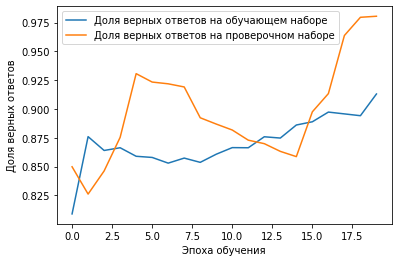

In [ ]:
#Создаём полносвязную сеть
model01 = Sequential()

model01.add(BatchNormalization(input_dim=maxWordsCount))
model01.add(Dropout(0.50))

model01.add(Dense(16, activation="relu"))

model01.add(Dropout(0.50))
model01.add(BatchNormalization())

model01.add(Dense(6, activation='sigmoid'))

model01.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

#Обучаем сеть на bag of words
history = model01.fit(xTrain01, 
                      yTrain, 
                      epochs=20,
                      batch_size=128,
                      validation_data=(xTest01, yTest))

plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [ ]:
model01.evaluate(xTest01, yTest) #лучшая точность

103/103 [==============================] - 0s 2ms/step - loss: 0.2829 - accuracy: 0.9806


[0.2828596830368042, 0.9805530309677124]

#Проверка работы сети

In [ ]:
# Проверим работу сети
def createTestMultiClasses(wordIndexes, xLen, step):

  nClasses = len(wordIndexes)
  xTest6Classes01 = [] 
  xTest6Classes = []   
  for wI in wordIndexes: 
    sample = (getSetFromIndexes(wI, xLen, step)) 
    xTest6Classes.append(sample)              
    xTest6Classes01.append(tokenizer.sequences_to_matrix(sample)) 
  xTest6Classes01 = np.array(xTest6Classes01)                     
  xTest6Classes = np.array(xTest6Classes)                     
  
  return xTest6Classes01, xTest6Classes 

# Распознаём тестовую выборку и выводим результаты
def recognizeMultiClass(model, xTest, modelName):
  print("НЕЙРОНКА: ", modelName)
  print()
  
  totalSumRec = 0 # Сумма всех правильных ответов
  
  #Проходим по всем классам
  for i in range(nClasses):
    #Получаем результаты распознавания класса по блокам слов длины xLen
    currPred = model.predict(xTest[i])
    #Определяем номер распознанного класса для каждохо блока слов длины xLen
    currOut = np.argmax(currPred, axis=1)

    evVal = []
    for j in range(nClasses):
      evVal.append(len(currOut[currOut==j])/len(xTest[i]))

    totalSumRec += len(currOut[currOut==i])
    recognizedClass = np.argmax(evVal) #Определяем, какой класс в итоге за какой был распознан
    
    #Выводим результаты распознавания по текущему классу
    isRecognized = "Это НЕПРАВИЛЬНЫЙ ответ!"
    if (recognizedClass == i):
      isRecognized = "Это ПРАВИЛЬНЫЙ ответ!"
    str1 = 'Класс: ' + className[i] + " " * (11 - len(className[i])) + str(int(100*evVal[i])) + "% сеть отнесла к классу " + className[recognizedClass]
    print(str1, " " * (55-len(str1)), isRecognized, sep='')
  
  #Выводим средний процент распознавания по всем классам вместе
  print()
  sumCount = 0
  for i in range(nClasses):
    sumCount += len(xTest[i])
  print("Средний процент распознавания ", int(100*totalSumRec/sumCount), "%", sep='')

  print()
  
  return totalSumRec/sumCount

In [ ]:
xTest6Classes01, _ = createTestMultiClasses(testWordIndexes, xLen, step) #Преобразование тестовой выборки

In [ ]:
#Проверяем точность нейронки обученной на bag of words
pred = recognizeMultiClass(model01, xTest6Classes01, "Тексты 01 + Dense")

НЕЙРОНКА:  Тексты 01 + Dense

Класс: О. Генри   100% сеть отнесла к классу О. Генри  Это ПРАВИЛЬНЫЙ ответ!
Класс: Стругацкие 98% сеть отнесла к классу Стругацкие Это ПРАВИЛЬНЫЙ ответ!
Класс: Булгаков   99% сеть отнесла к классу Булгаков   Это ПРАВИЛЬНЫЙ ответ!
Класс: Саймак     96% сеть отнесла к классу Саймак     Это ПРАВИЛЬНЫЙ ответ!
Класс: Фрай       95% сеть отнесла к классу Фрай       Это ПРАВИЛЬНЫЙ ответ!
Класс: Брэдберри  100% сеть отнесла к классу Брэдберри Это ПРАВИЛЬНЫЙ ответ!

Средний процент распознавания 98%

